# Importing Equity and Accessibility Data

The paper explores whether these patterns appear to represent tradeoffs between driving and housing costs, and what they mean for the housing and driving expenditure burdens faced by different groups of people in Los Angeles County. To explain this variation, the paper will use a Multi-Level Model (MLM) and Artificial Neural Network (ANN) to model patterns accessibility to employment opportunities in Los Angeles. The paper will use household level data consisting of individual travel surveys from data in the California Household Travel Survey (CHTS), and block group level data from the Housing and Transportation Affordability Index (Center for Neighbourhood Technology 2012). The results will indicate that MLM offers good predictive accuracy with high explanatory power, and can explore the variation of neighbourhood effects at multiple spatial scales.

## Equity - Data Description ##

- Based on the `block group` and `equity` dataframes, determine for each block group in L.A. create an equity index based on the results of a  multi-level model.
    -  This will require building a multilevel model using the H+T affordability index
- Using the equity index as a training data set, train a neural network to predict block-level accessibility in L.A. County
- Compare the residuals of the Artificial Neural Network and the Multilevel model in their ability to correctly predict accessibility based on the constructed equity index.

We will make use of some data description packages first.

In [66]:
import pandas as pd
import geopandas
import numpy as np
import fiona
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10

In this data there is equity data for over 26,000 households situated in 10,631 block groups.

In [69]:
Equity = pd.read_csv('Equity_ethnicity_data.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x)}
)
Equity.head()

,Unnamed: 0,X,ID,Tract,blkgrp,cbsa,blkgrps,population,households,land_acres,...,White.alone,Black.or.African.American.alone,American.Indian.and.Alaska.Native.alone,Asian.alone,Native.Hawaiian.and.Other.Pacific.Islander.alone.1,Some.other.race.alone.1,Two.or.more.races.,Two.races.including.Some.other.race.1,Two.races.excluding.Some.other.race..and.three.or.more.races.1,GEOID10
0,1,1,1,Census Tract 1011.10,"""060371011101""","Los Angeles, CA",1,1916,621,110.53,...,772.0,0.0,0.0,0.0,0.0,849.0,21.0,9.0,12.0,060371011101
1,2,2,2,Census Tract 1011.10,"""060371011102""","Los Angeles, CA",1,1768,597,87.58,...,772.0,0.0,0.0,0.0,0.0,849.0,21.0,9.0,12.0,060371011102
2,3,3,3,Census Tract 1011.10,"""060371011103""","Los Angeles, CA",1,1140,427,84.19,...,772.0,0.0,0.0,0.0,0.0,849.0,21.0,9.0,12.0,060371011103
3,4,4,4,Census Tract 1011.22,"""060371011221""","Los Angeles, CA",1,2129,785,392.91,...,167.0,0.0,8.0,0.0,0.0,180.0,68.0,43.0,25.0,060371011221
4,5,5,5,Census Tract 1011.22,"""060371011222""","Los Angeles, CA",1,1162,433,260.45,...,167.0,0.0,8.0,0.0,0.0,180.0,68.0,43.0,25.0,060371011222


And remove all columns with `NA` values

In [70]:
Equity_no_NA = Equity.dropna()

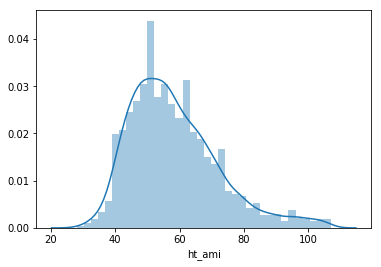

In [74]:
sns.distplot(Equity_no_NA['ht_ami'])

In [71]:
block_groups = geopandas.read_file("data/CENSUS_BLOCK_GROUPS_2010.shp")
block_groups.head()

,GEOID10,CTBG10,CT10,AreaSqMil,LABEL,FIP10,FIP10RV,CDP_NAME,CITYNAME,COMMNAME,Shape_STAr,Shape_STLe,geometry
0,060372932023,2932023,293202,0.2272,BG 3,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,6.334870e+06,10809.732641,"POLYGON ((6470819.156994522 1756917.221350595,..."
1,060372941201,2941201,294120,0.3144,BG 1,44000,44000,Los Angeles,Los Angeles,LA City - Wilmington,8.764387e+06,12908.543740,"POLYGON ((6486934.539133772 1749706.324683189,..."
2,060372932022,2932022,293202,0.0965,BG 2,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,2.689751e+06,9129.549876,"POLYGON ((6470825.268202782 1757848.131234184,..."
3,060372932021,2932021,293202,0.0827,BG 1,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,2.304498e+06,9332.023680,"POLYGON ((6470794.623579025 1759084.12187244, ..."
4,060372941101,2941101,294110,0.1251,BG 1,44000,44000,Los Angeles,Los Angeles,LA City - Wilmington,3.487909e+06,9057.642084,"POLYGON ((6483144.067712113 1749495.294593439,..."


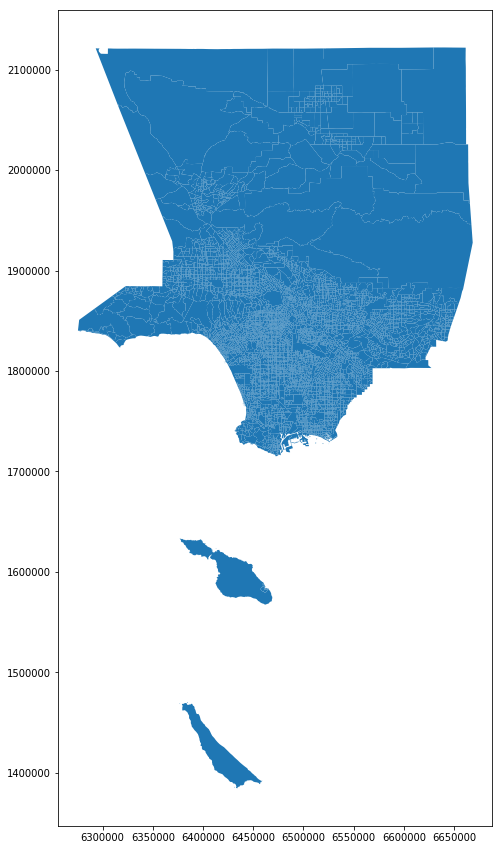

In [72]:
block_groups.plot(figsize=(15, 15))

In [76]:
Equity_block_groups = block_groups.merge(Equity_no_NA, on='GEOID10')
Equity_block_groups.head()

,GEOID10,CTBG10,CT10,AreaSqMil,LABEL,FIP10,FIP10RV,CDP_NAME,CITYNAME,COMMNAME,...,Hispanic.or.Latino.,White.alone,Black.or.African.American.alone,American.Indian.and.Alaska.Native.alone,Asian.alone,Native.Hawaiian.and.Other.Pacific.Islander.alone.1,Some.other.race.alone.1,Two.or.more.races.,Two.races.including.Some.other.race.1,Two.races.excluding.Some.other.race..and.three.or.more.races.1
0,060372932023,2932023,293202,0.2272,BG 3,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,...,4244.0,1277.0,0.0,0.0,15.0,0.0,2757.0,195.0,123.0,72.0
1,060372932022,2932022,293202,0.0965,BG 2,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,...,4244.0,1277.0,0.0,0.0,15.0,0.0,2757.0,195.0,123.0,72.0
2,060372932021,2932021,293202,0.0827,BG 1,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,...,4244.0,1277.0,0.0,0.0,15.0,0.0,2757.0,195.0,123.0,72.0
3,060372932011,2932011,293201,0.1244,BG 1,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,...,3137.0,1240.0,0.0,13.0,0.0,0.0,1319.0,565.0,481.0,84.0
4,060372932012,2932012,293201,0.1562,BG 2,44000,44000,Los Angeles,Los Angeles,LA City - Harbor City,...,3137.0,1240.0,0.0,13.0,0.0,0.0,1319.0,565.0,481.0,84.0


We will first explore the combined Housing + Transportation Costs % Income for the Regional Typical Household (summarised at the block group level). This is called as `ht_ami` within the `Equity_block_groups.csv` dataframe.
- Lets first explore the numeric and spatial distribution of the data.

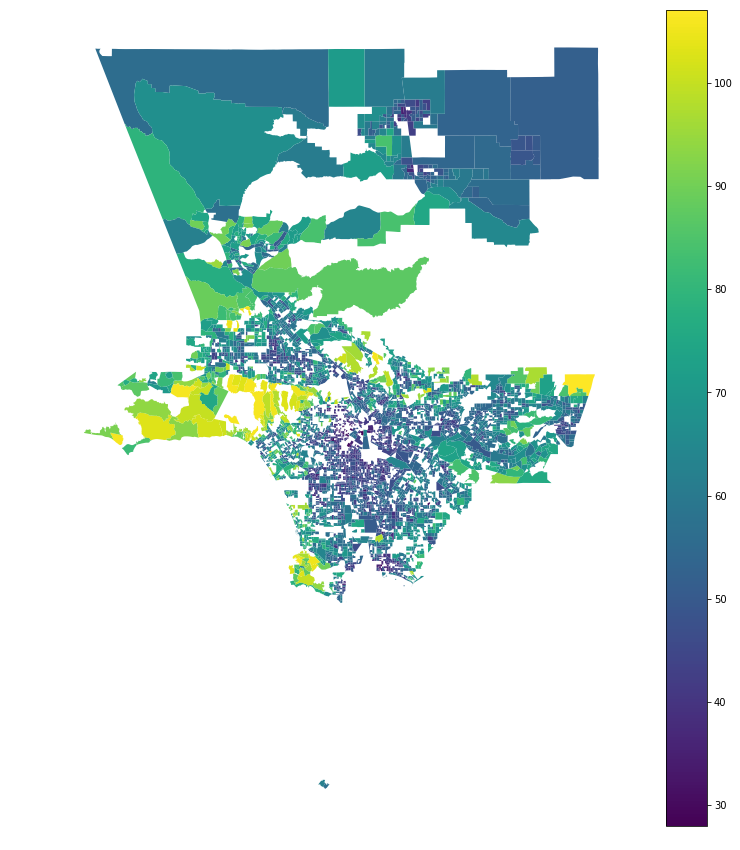

In [77]:
ht_ami = Equity_block_groups.plot(figsize=(15, 15), column='ht_ami',legend=True)
ht_ami.set_axis_off()

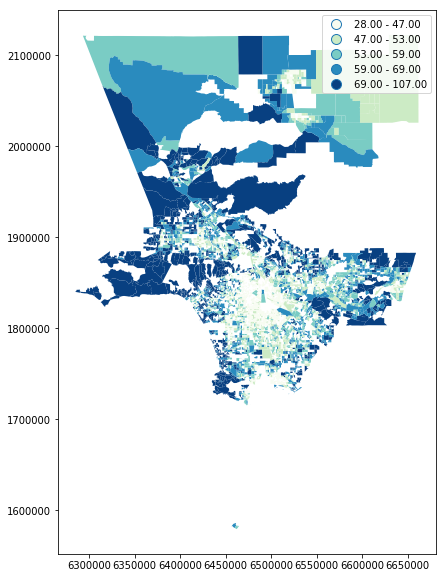

In [78]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
Equity_block_groups.plot(column='ht_ami', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax)

## Multilevel Modeling Equity indicators using PyStan

Multilevel models are regression models in which the constituent model parameters are given probability models. This implies that model parameters are allowed to vary by group.

Observational units are often naturally *clustered*. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A hierarchical model is a particular multilevel model where parameters are nested within one another.
- In this case, `block groups` are nested within `tracts` in L.A. 
    -  Therefore the model will include measures of equity using the H+T affordability index to predict patterns of accessibility to employment opportunities in L.A. County.
    -  These predictions of equity will be used to inform an `equity index` which will be analysed for residual patterns.


In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
All_data = pd.read_csv('data_block_clean.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x)}
)
All_data.head()

,Unnamed: 0,ID,GEOID10,Tract,bBlockID,BlockID,bBlockGrpID,blkgrp,bTractID,Tot_r_10,...,Income_2017,X5_yr_change,Tot_tract_pop,White_alone,Black_African_American,Indian_Alaskan_Native,Asian_alone,Pacific_alone,Other_alone,Hispanic
0,1,1,060371011101000,"""06037101110""",b060371011101000,60371011101000,b060371011101,"""060371011101""",b06037101110,9407.8979,...,75694.0,0.383,4667.0,2572.0,54.0,0.0,307.0,3.0,0.0,1642.0
1,2,2,060371011101007,"""06037101110""",b060371011101007,60371011101007,b060371011101,"""060371011101""",b06037101110,10492.4500,...,75694.0,0.383,4667.0,2572.0,54.0,0.0,307.0,3.0,0.0,1642.0
2,3,3,060371011101008,"""06037101110""",b060371011101008,60371011101008,b060371011101,"""060371011101""",b06037101110,10283.7200,...,75694.0,0.383,4667.0,2572.0,54.0,0.0,307.0,3.0,0.0,1642.0
3,4,4,060371011101011,"""06037101110""",b060371011101011,60371011101011,b060371011101,"""060371011101""",b06037101110,10238.5000,...,75694.0,0.383,4667.0,2572.0,54.0,0.0,307.0,3.0,0.0,1642.0
4,5,5,060371011102004,"""06037101110""",b060371011102004,60371011102004,b060371011102,"""060371011102""",b06037101110,11543.9900,...,31667.0,-0.325,4667.0,2572.0,54.0,0.0,307.0,3.0,0.0,1642.0


We also need a lookup table (`dict`) for each unique block, for indexing.

In [81]:
All_data.BlockID_str = All_data.bBlockID.str.strip('b')
All_data_block = All_data.BlockID_str.unique()
blocks = len(All_data_block)
blocks

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


29438

Finally, create local copies of variables.

In [88]:
blocks_lookup = dict(zip(All_data_block, range(len(All_data_block))))
block = All_data['block_code'] = All_data.BlockID_str.replace(blocks_lookup).values
ht_ami = All_data.ht_ami
All_data['ht_ami'] = log_ht_ami = np.log(ht_ami + 0.1).values
Tot_r_10 = All_data.Tot_r_10.values

Distribution of Housing + Transportation Costs % Income for the Regional Typical Household levels in L.A. County (log scale):

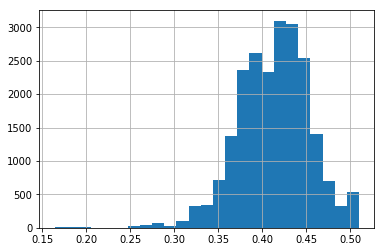

In [89]:
All_data.ht_ami.apply(lambda x: np.log(x+0.1)).hist(bins=25)

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo.

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

### Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

To specify this model in Stan, we begin by constructing the `data` block, which includes vectors of log-radon measurements (`y`) and floor measurement covariates (`x`), as well as the number of samples (`N`).

In [90]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""

Next we initialize our parameters, which in this case are the linear model coefficients and the normal scale parameter. Notice that `sigma` is constrained to be positive.

In [91]:
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

Finally, we model the `log_ht_ami` measurements as a normal sample with a mean that is a function of the floor measurement.

In [92]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

In [ ]:
import pystan

pooled_data_dict = {'N': len(log_ht_ami),
               'x': log_ht_ami,
               'y': Tot_r_10}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model, 
                         data=pooled_data_dict, iter=10, chains=10)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***.

### Partial pooling model

The simplest partial pooling model for the block Housing + Transportation Costs % Income dataset is one which simply estimates H+T Costs, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled block estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

- Estimates for blocks with smaller sample sizes will shrink towards the block group estimates.
- Estimates for blocks with larger sample sizes will be closer to the block group estimates.
    -   This results in two standard deviations, one describing the residual error of the observations, and another the variability of the block means around their block group average.

In [57]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=> blocks[N];
  vector[N] y;
} 
parameters {
  vector[85] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[blocks[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);

  y ~ normal(y_hat, sigma_y);
}"""

In [59]:
partial_pool_data = {'N': len(log_ht_ami),
               'blocks': blocks+1, # Stan counts starting at 1
               'y': log_ht_ami}

partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=2)

ValueError: Failed to parse Stan model 'anon_model_647af1d3e9ffbffe04844067ceae969c'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

  error in 'unknown file name' at line 4, column 6
  -------------------------------------------------
     2: data {
     3:   int<lower=0> N; 
     4:   int<lower=1,upper=> blocks[N];
             ^
     5:   vector[N] y;
  -------------------------------------------------

PARSER EXPECTED: <identifier>


## Accessibility - Data Description ##

- Based on the `blocks` and `accessibility` dataframes, determine for each block in L.A. the level of total accessibility for a 10 minute journey by private transportation.

In [37]:
Accessibility = pd.read_csv('Accessibility_block.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x)}
)
Accessibility.head()

,Unnamed: 0,X,ID,bBlockID,BlockID,bBlockGrpID,blkgrp,bTractID,Tract,Tract_descr,...,Sqrt_Tot_t_10,Sqrt_Tot_t_20,Sqrt_Tot_t_50,Sqrt_Ent_t_10,Sqrt_Ent_t_20,Sqrt_Ent_t_50,Sqrt_Ret_t_10,Sqrt_Ret_t_20,Sqrt_Ret_t_50,GEOID10
0,1,1,1,b060371011101000,60371011101000,b060371011101,"""060371011101""",b06037101110,"""06037101110""",Census Tract 1011.10,...,6.335902,14.621508,52.422963,0.981454,2.348834,13.656061,1.873051,2.597940,21.099953,060371011101000
1,2,2,2,b060371011101007,60371011101007,b060371011101,"""060371011101""",b06037101110,"""06037101110""",Census Tract 1011.10,...,9.039653,24.903933,96.962874,1.918671,4.701627,23.033671,1.849784,6.012213,36.607240,060371011101007
2,3,3,3,b060371011101008,60371011101008,b060371011101,"""060371011101""",b06037101110,"""06037101110""",Census Tract 1011.10,...,7.183704,19.481039,84.058188,1.370923,3.649918,18.316441,1.664506,4.468120,32.973323,060371011101008
3,4,4,5,b060371011101011,60371011101011,b060371011101,"""060371011101""",b06037101110,"""06037101110""",Census Tract 1011.10,...,4.719245,15.218587,61.417717,0.749351,2.915539,14.007391,0.663957,2.918688,23.594788,060371011101011
4,5,5,6,b060371011102004,60371011102004,b060371011102,"""060371011102""",b06037101110,"""06037101110""",Census Tract 1011.10,...,11.885411,31.947128,115.364206,2.636209,7.655253,28.862987,2.673154,12.420507,41.382122,060371011102004


We ensure the 'BlockID' column in the `Accessibility` dataset retains its leading 0, indicating a code of the block in L.A. County. This block code is also present in the geographic `blocks` dataset, which allows us to merge those two dataframes based on the common column.

Let's start by reading a shapefile with all the blocks in Los Angeles County of the world (adapted from https://egis3.lacounty.gov/dataportal/2016/01/26/census_blocks/, zip file is available in the /data directory), and inspect the data:

In [38]:
blocks = geopandas.read_file("data/CB2010.shp")

In [39]:
blocks.head()

,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,Shape_Leng,Shape_Area,geometry
0,1,060373006004026,3006004026,3006004,6491598.17,1894183.22,City of Glendale,4026,9159.546114,1.913977e+06,"POLYGON ((6490744.246737435 1895678.104261369,..."
1,2,060373106012020,3106012020,3106012,6463016.10,1892084.44,City of Burbank,2020,1964.973838,5.418113e+04,"POLYGON ((6463033.288051859 1892277.416180864,..."
2,3,060373102023003,3102023003,3102023,6472190.58,1891670.58,City of Burbank,3003,2603.561228,2.114448e+05,"POLYGON ((6472630.051666722 1892009.059434116,..."
3,4,060373007015000,3007015000,3007015,6489801.10,1896240.05,City of Glendale,5000,4926.789101,1.239509e+05,"POLYGON ((6490274.876941279 1895512.891993374,..."
4,5,060373007015006,3007015006,3007015,6491845.66,1892157.14,City of Glendale,5006,2753.561825,3.285580e+05,"POLYGON ((6492204.176232278 1891871.050523788,..."


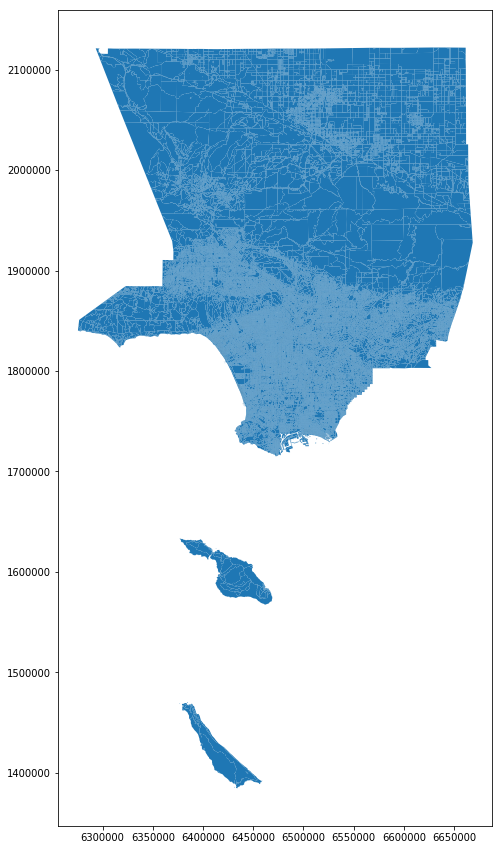

In [40]:
blocks.plot(figsize=(15, 15))

Joining the `Accessibility` dataframe with the blocks data will transfer extra information about the `blocks` (the name of the city the block is in, its lat and long) to the Accessibility dataframe, based on a common key.

In [41]:
Accessibility_blocks = blocks.merge(Accessibility, on='GEOID10')
Accessibility_blocks.head()

,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,Shape_Leng,Shape_Area,...,LOG_Ret_r_50,Sqrt_Tot_t_10,Sqrt_Tot_t_20,Sqrt_Tot_t_50,Sqrt_Ent_t_10,Sqrt_Ent_t_20,Sqrt_Ent_t_50,Sqrt_Ret_t_10,Sqrt_Ret_t_20,Sqrt_Ret_t_50
0,16,060371232051005,1232051005,1232051,6445554.32,1892202.32,Los Angeles - North Hollywood,1005,2030.372010,226085.829949,...,11.651704,28.307896,70.735218,457.237247,7.336975,15.108309,108.761666,10.575018,33.157503,150.379852
1,19,060371232051006,1232051006,1232051,6445884.31,1892201.39,Los Angeles - North Hollywood,1006,2030.310561,226129.380184,...,11.660656,24.393491,65.485716,357.628438,6.172957,15.773015,88.943072,8.872023,30.332689,124.151520
2,21,060371232032000,1232032000,1232032,6444230.39,1893845.80,Los Angeles - North Hollywood,2000,3344.935904,463073.955057,...,11.671859,22.647786,82.436570,462.310826,4.350586,17.270842,122.785993,7.706439,36.581143,151.699374
3,23,060374800022001,4800022001,4800022,6535759.10,1868903.04,Unincorporated - East San Gabriel,2001,2692.548391,388868.021209,...,10.778769,3.867482,11.276834,159.151312,0.000000,0.778221,53.018204,1.235172,2.726419,60.269395
4,25,060374801023006,4801023006,4801023,6535728.97,1861398.02,Unincorporated - East San Gabriel,3006,2129.666380,264894.139606,...,10.539350,11.187745,34.290628,252.365341,4.712059,11.823663,63.323218,3.629683,12.138946,87.283160


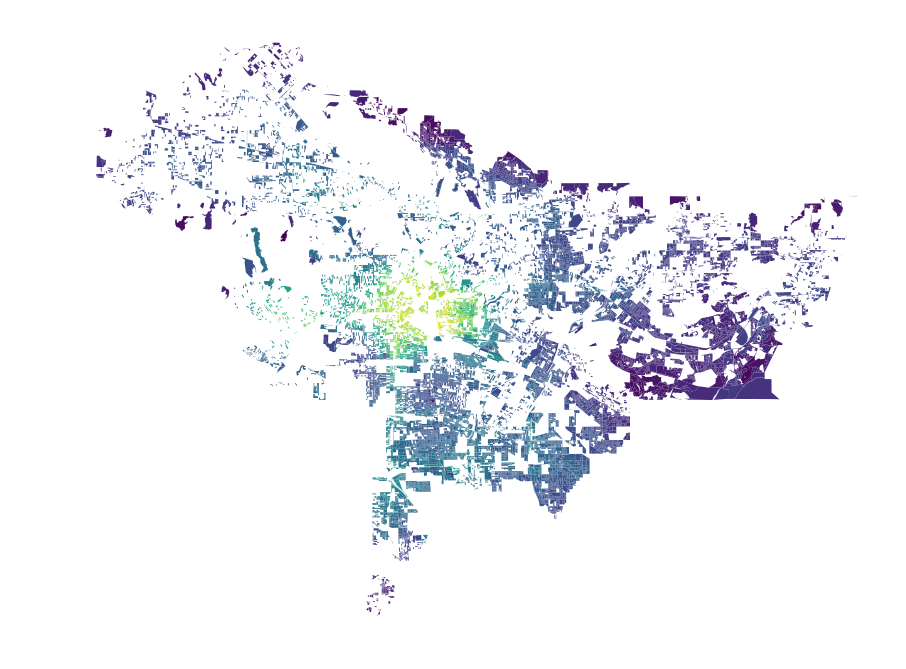

In [42]:
Tot_r_10 = Accessibility_blocks.plot(figsize=(15, 15), column='Tot_r_10')
Tot_r_10.set_axis_off()

## Data Classification
More formally, the classification problem is to define class boundaries such
that
$$
c_j < y_i \le  c_{j+1} \ \forall y_i \in C_{j+1}
$$
where $y_i$ is the
value of the attribute for spatial location $i$, $j$ is a class index, and $c_j$
represents the lower bound of interval $j$.

We can use `seaborn` to visualize the statistical distribution of the median
level of accessibility in 10 minutes by private vehicle of the blocks:

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


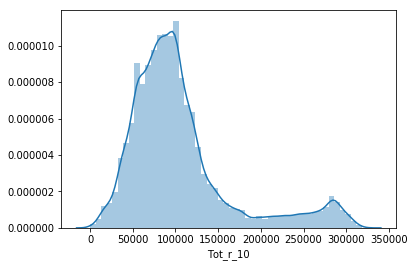

In [43]:
sbn.distplot(Accessibility['Tot_r_10'])

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


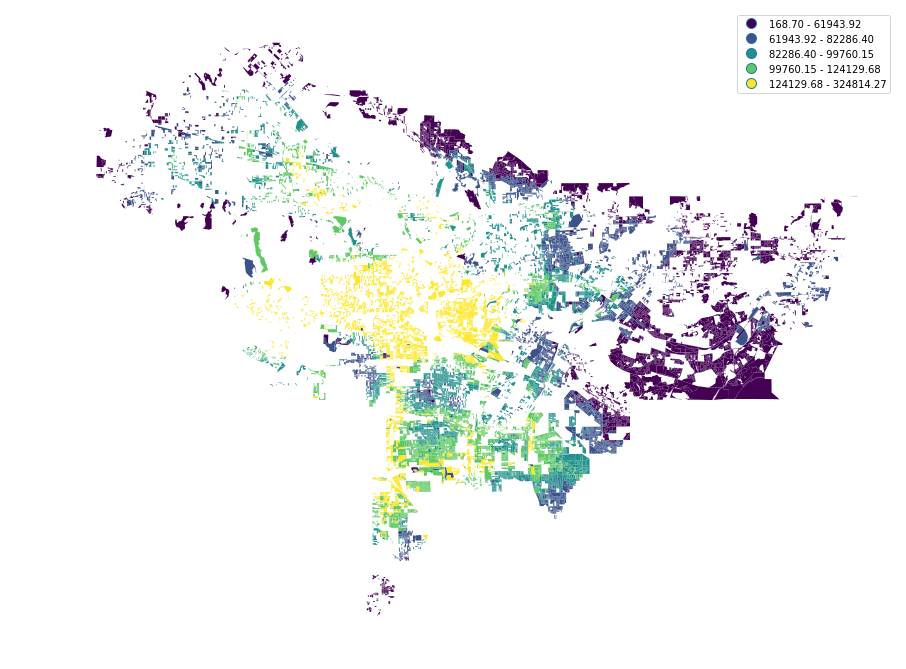

In [44]:
Tot_r_10 = Accessibility_blocks.plot(figsize=(15, 15), column='Tot_r_10',scheme='quantiles', legend=True)
Tot_r_10.set_axis_off()

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


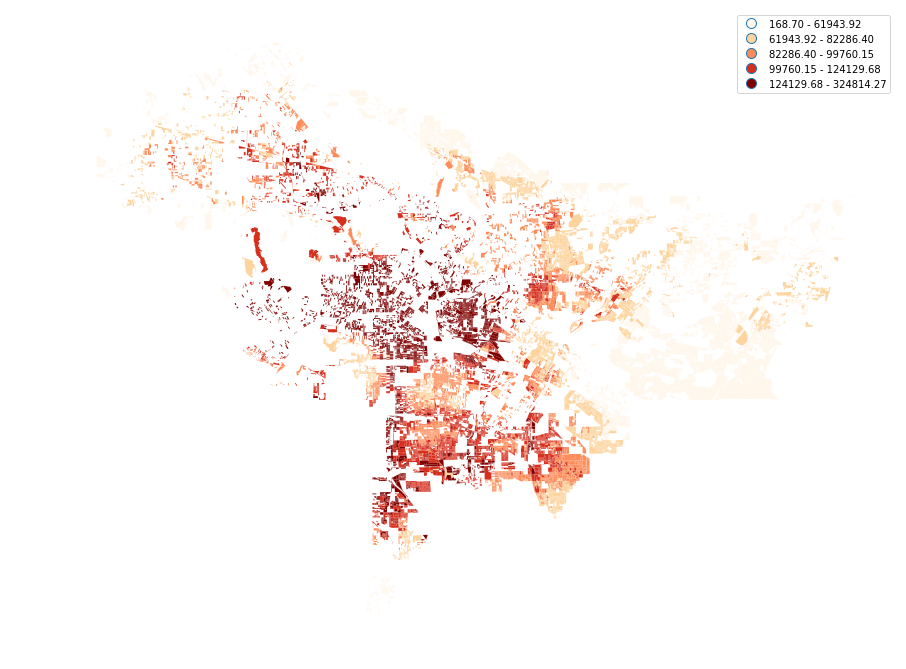

In [45]:
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'aspect':'equal'})
Accessibility_blocks.plot(column='Tot_r_10', legend=True, scheme='Quantiles', ax=ax, cmap='OrRd')
ax.set_axis_off()

Alternatively, we can change the classification scheme

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


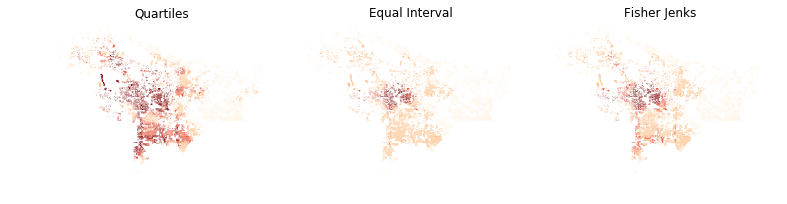

In [46]:
f,ax = plt.subplots(1,3,figsize=(3.16*4,4), subplot_kw=dict(aspect='equal'))
Accessibility_blocks.plot(column='Tot_r_10', ax=ax[0],
        scheme="quantiles", cmap='OrRd', k=4)
ax[0].axis(Accessibility_blocks.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Quartiles")
Accessibility_blocks.plot(column='Tot_r_10', ax=ax[1],
        scheme='equal_interval', cmap='OrRd', k=4)
ax[1].axis(Accessibility_blocks.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Equal Interval")
Accessibility_blocks.plot(column='Tot_r_10', ax=ax[2],
       scheme='fisher_jenks', cmap='OrRd', k=4)
ax[2].axis(Accessibility_blocks.total_bounds[np.asarray([0,2,1,3])])
ax[2].set_title("Fisher Jenks")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

### Selecting a classification based on fit ###

To have a balance between maximizing the
differences between Accessibility observations in each bin, and minimizing the intra-bin heterogeneity, PySAL classifiers have underlying measures of fit for this purpose. 

One such measure is the the `absolute deviation around class medians` (ADCM). Let's use this to compare all k=5 classifiers:

In [47]:
import mapclassify as mc

In [48]:
y = Accessibility_blocks['Tot_r_10']

In [49]:
q5 = mc.Quantiles(y, k=5)
ei5 = mc.Equal_Interval(y, k=5)
mb5 = mc.Maximum_Breaks(y, k=5)
fj5 = mc.Fisher_Jenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[314364924.6149005, 271719411.24459946, 775661158.0448064, 216104090.00370017]

Fisher Jenks is the optimal classifer. 

### Using mapclassify with GeoPandas

In [50]:
bp = mc.Box_Plot(y)
bp

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


                     Box Plot                     
 
  Lower                Upper                 Count
             x[i] <=  -5169.684                  0
 -5169.684 < x[i] <=  67955.739               5087
 67955.739 < x[i] <=  91128.812               5087
 91128.812 < x[i] <= 116706.021               5086
116706.021 < x[i] <= 189831.444               3290
189831.444 < x[i] <= 324814.269               1797

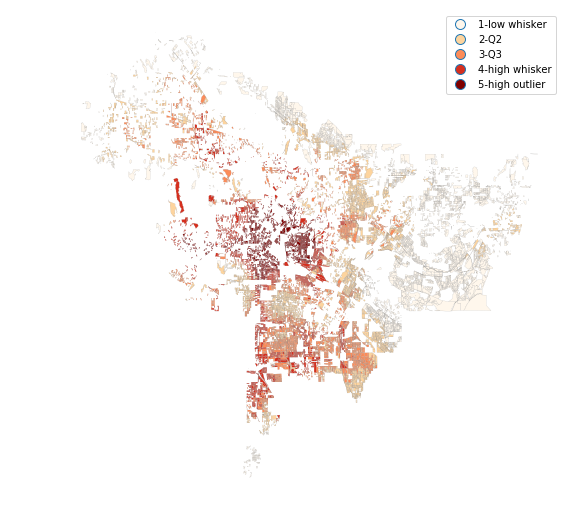

In [52]:
labels = ['0-low outlier', '1-low whisker',
          '2-Q2', '3-Q3', '4-high whisker', '5-high outlier']
bpl = [ labels[b] for b in bp.yb ]


f, ax = plt.subplots(1, figsize=(9, 9))
Accessibility_blocks.assign(cl=bpl).plot(column='cl', categorical=True, \
                                      k=4, cmap='OrRd', linewidth=0.1, ax=ax,\
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of Accessibility was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues () in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

### Attribute Distribution (a-spatial) ###

In [53]:
import libpysal as lp
import matplotlib.pyplot as plt
import rasterio as rio
import contextily as ctx
import shapely.geometry as geom
import seaborn as sbn
%matplotlib inline

The histogram reflect a right-skewed distribution, or urban accessibility distributions.

This study selects Los Angeles County as the study area as it has a diversified range of transportation options, diversified urban and rural mixture and includes affluent suburbs and inner city dwellings. 

All settings expose households to varying levels of accessibility and equity. The target of inference is the between census-block groups in differences in general, this requires a large amount of census block groups to get a reliable estimate.

Transportation and housing expenditures vary by neighbourhood. Lower income households - in particular households without automobiles, are likely to live in dense urban neighbourhoods within close proximity to public transport. However, although transportation costs tend to be low, households in  central neighbourhoods tend to induce high housing costs (per square foot). 

We measure household and transportation affordability using the H+T Index (https://htaindex.cnt.org/). 